# Sarcasm Detection Classification


### Importing Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.utils.fixes import signature

%matplotlib inline

import re
import warnings

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
#nltk.download('brown')
#nltk.download('punkt')
#nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading The Dataset

In [2]:
your_local_path = "F:/kanchan/job 2019/for GIT/Sarcasm_detection/" 
train = pd.read_csv('train.csv')

In [3]:
your_local_path = "F:/kanchan/job 2019/for GIT/Sarcasm_detection/"  
test = pd.read_csv('test.csv')

### Exploratory Data Analysis

Let's have a look at the dataset

In [4]:
train.head()

,Unnamed: 0,article_link,headline,is_sarcastic
0,19691,https://local.theonion.com/cat-internally-deba...,cat internally debates whether or not to rip h...,1
1,17031,https://www.theonion.com/new-college-freshman-...,new college freshman refers to dorm by actual ...,1
2,8979,https://www.huffingtonpost.com/entry/deputy-br...,viral photo captures incredible moment between...,0
3,17805,https://www.huffingtonpost.com/entry/limits-or...,limits or limitless?,0
4,2900,https://entertainment.theonion.com/charlton-he...,"charlton heston's gun taken from his cold, dea...",1


In [5]:
test.head()

,Unnamed: 0,article_link,headline
0,6913,https://www.huffingtonpost.com/entry/paul-ryan...,paul ryan is more of a con man than ever
1,11611,https://www.huffingtonpost.com/entry/to-breast...,"to breast or bottle feed, a woman's choice: le..."
2,25947,https://www.theonion.com/chili-s-introduces-sa...,chili's introduces savory new 200-times-baked ...
3,24478,https://www.huffingtonpost.com/entry/5-friends...,5 friendship lessons you learned on the playgr...
4,11863,https://www.huffingtonpost.com/entry/remember-...,remembering high school


In [6]:
# Shape of the dataset
print('Training Set: ', train.shape)
print('Testing Set: ', test.shape)

Training Set:  (20031, 4)
Testing Set:  (6678, 3)


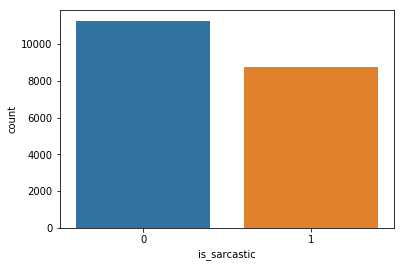

In [7]:
# Lets see the number of datapoints in each category.
sns.countplot(x = 'is_sarcastic', data = train)

In [8]:
train['is_sarcastic'].value_counts()

0    11276
1     8755
Name: is_sarcastic, dtype: int64

 So the data is spread in 56:44 ratio.

In [9]:
#data cleaning
train['headline'] = train['headline'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
train['headline'] = train['headline'].apply(lambda x: re.sub('  ', ' ', x))
train['headline'][3]

'limits or limitless'

In [10]:
#Classifying the datapoints into Happy, Neutral and Sad categories as Sentiments based on their polarity index.
train['sentiment'] = train['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['sentiment_type'] = ''
train.loc[train.sentiment >= 0,'sentiment_type'] = 'HAPPY'
train.loc[train.sentiment == 0,'sentiment_type'] = 'NEUTRAL'
train.loc[train.sentiment < 0,'sentiment_type'] = 'SAD'

In [11]:
train.head()

,Unnamed: 0,article_link,headline,is_sarcastic,sentiment,sentiment_type
0,19691,https://local.theonion.com/cat-internally-deba...,cat internally debates whether or not to rip h...,1,0.000000,NEUTRAL
1,17031,https://www.theonion.com/new-college-freshman-...,new college freshman refers to dorm by actual ...,1,0.068182,HAPPY
2,8979,https://www.huffingtonpost.com/entry/deputy-br...,viral photo captures incredible moment between...,0,0.900000,HAPPY
3,17805,https://www.huffingtonpost.com/entry/limits-or...,limits or limitless,0,0.000000,NEUTRAL
4,2900,https://entertainment.theonion.com/charlton-he...,charlton heston's gun taken from his cold dead...,1,-0.400000,SAD


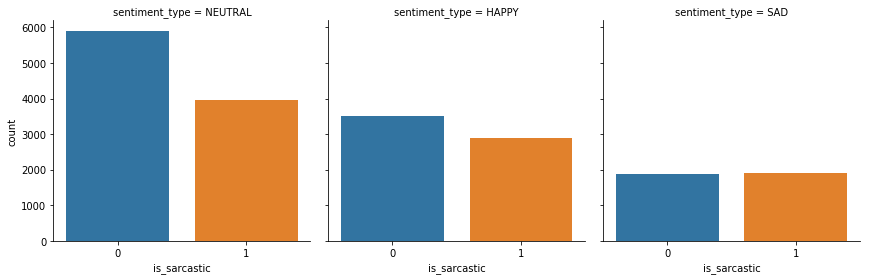

In [12]:
sns.factorplot(x = 'is_sarcastic', col = 'sentiment_type', kind = 'count', data = train);



*For NEUTRAL Category*, we have approx, 6000 not sarcastic comments and approx 4000 sarcastic comment.

*For HAPPY(Positive) Category*, we have approx, 3700 not sarcastic comments and approx 3000 sarcastic comment.

*For SAD(Negative) Category*, we have approx, 1900 not sarcastic comments and approx 1900 sarcastic comment.

With this distribution it is very difficult to categorize the comments into sarcastic ot not sarcatic comments based on their sentiments categories.

### Data Preparation

In [13]:
train.columns

Index(['Unnamed: 0', 'article_link', 'headline', 'is_sarcastic', 'sentiment',
       'sentiment_type'],
      dtype='object')

In [14]:
test.columns

Index(['Unnamed: 0', 'article_link', 'headline'], dtype='object')

In [15]:
# Deleting the unwanted columns 
train = train.drop(columns = ['Unnamed: 0', 'article_link', 'sentiment', 'sentiment_type'], axis = 1)

# Performing the same operation on test dataset
test = test.drop(columns = ['Unnamed: 0', 'article_link'], axis = 1)

In [16]:
# Lets have a final look at the Dataset
train.head()

,headline,is_sarcastic
0,cat internally debates whether or not to rip h...,1
1,new college freshman refers to dorm by actual ...,1
2,viral photo captures incredible moment between...,0
3,limits or limitless,0
4,charlton heston's gun taken from his cold dead...,1


Now, when we do feature engineering using CountVectorization, the number of columns increases in the training dataset. And when we perform the same Countvectorisation on Test dataset, the outcome has different number of columns compared to Training set. Hence I wil concat the training and testing dataset and perform the feature engineering together.

In [17]:
train['label'] = 'train'
test['label'] = 'test'

In [18]:
test.head()

,headline,label
0,paul ryan is more of a con man than ever,test
1,"to breast or bottle feed, a woman's choice: le...",test
2,chili's introduces savory new 200-times-baked ...,test
3,5 friendship lessons you learned on the playgr...,test
4,remembering high school,test


In [19]:
concat_df = pd.concat([train , test])

In [20]:
concat_df.shape

(26709, 3)

### Feature Engineering

**CountVectorizer**

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

In [21]:
# Extracting features from text files
# CountVectorizer
count_vect = CountVectorizer()
concat_df_counts = count_vect.fit_transform(concat_df.headline)
concat_df_counts.shape

(26709, 25409)

**TFIDF Tranformerr**

Transform a count matrix to a normalized tf or tf-idf representation

In [22]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
concat_df_tfidf = tfidf_transformer.fit_transform(concat_df_counts)
concat_df_tfidf.shape

(26709, 25409)

In [23]:
# Splitting the Dataset
X = concat_df_tfidf
y = np.array(concat_df['label'])
a_test = np.where(y == 'test')
a_train = np.where(y == 'train')
test_mat = X[a_test]
train_mat = X[a_train]

In [24]:
# Defining the target variable
y = train.is_sarcastic

In [25]:
# Training and Validation Split
X_train, X_val, y_train, y_val = train_test_split(train_mat, y, test_size = 0.2, random_state = 42)

In [26]:
print('Shape of the Train and Validation Data:\n')
print('Training Data: ', X_train.shape)
print('Training Data(target): ', y_train.shape)
print('Validation Data: ', X_val.shape)
print('Validation Data(target): ', y_val.shape)

Shape of the Train and Validation Data:

Training Data:  (16024, 25409)
Training Data(target):  (16024,)
Validation Data:  (4007, 25409)
Validation Data(target):  (4007,)


### Modelling

Naive Bayes Classifier

In [27]:
NB_clf = MultinomialNB().fit(train_mat, y)

In [28]:
NB_predicted = NB_clf.predict(X_val)

In [29]:
metrics.confusion_matrix(y_val, NB_predicted)

array([[2162,   31],
       [ 349, 1465]], dtype=int64)

In [30]:
NB_cr = metrics.classification_report(y_val, NB_predicted)
print(NB_cr)

             precision    recall  f1-score   support

          0       0.86      0.99      0.92      2193
          1       0.98      0.81      0.89      1814

avg / total       0.91      0.91      0.90      4007



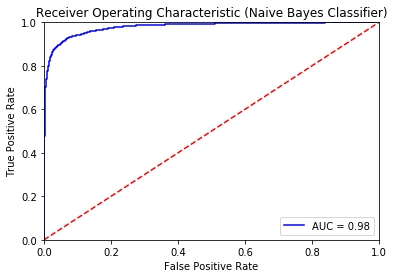

In [31]:
# calculate the fpr and tpr for all thresholds of the classification
probs = NB_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Naive Bayes Classifier)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test dataset

In [40]:
NB_predicted_test = NB_clf.predict(X_val)
NB_predicted_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [41]:
metrics.confusion_matrix(y_val, NB_predicted_test)

array([[2162,   31],
       [ 349, 1465]], dtype=int64)

In [42]:
NB_cr = metrics.classification_report(y_val, NB_predicted_test)
print(NB_cr)

             precision    recall  f1-score   support

          0       0.86      0.99      0.92      2193
          1       0.98      0.81      0.89      1814

avg / total       0.91      0.91      0.90      4007

